# Convergent Cross Mapping
This notebook and package is reproducing the results from [
Detecting Causality in Complex Ecosystems](http://science.sciencemag.org/content/338/6106/496)

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
sns.set_context(context='paper',font_scale=1.5)
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#alter the line below to correspond to your file system
#nonlinpy_dir = '/Users/nickc/Documents/skccm'
#sys.path.append('../')

In [4]:
import skccm as ccm
import skccm.data as data

## Work Flow
A coupled logistic map. Here is what we are going to do:

1. Generate the time series
2. Calculate the mutual information of the time series
3. Embed the time series (not going to explore embedding dimension, just lag)
4. Analyze forecast skill for a range of library lengths

### 1. Generate the time series

In [5]:
rx1 = 3.72 #determines chaotic behavior of the x1 series
rx2 = 3.72 #determines chaotic behavior of the x2 series
b12 = 0.2 #Influence of x1 on x2
b21 = 0.01 #Influence of x2 on x1
ts_length = 1000
x1,x2 = data.coupled_logistic(rx1,rx2,b12,b21,ts_length)

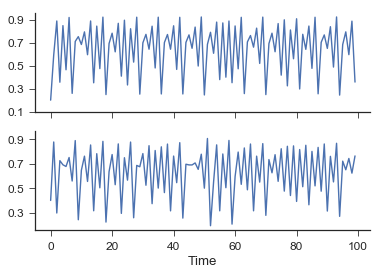

In [6]:
fig,ax = plt.subplots(nrows=2,sharex=True,sharey=True)
ax[0].plot(x1[0:100])
ax[1].plot(x2[0:100])
ax[0].set_yticks([.1,.3,.5,.7,.9])
ax[1].set_xlabel('Time')
sns.despine()

In [7]:
#fig.savefig('../figures/train_test_split/coupled_logistic.png',bbox_inches='tight')

### 2. Calculate the mutual information

In [8]:
e1 = ccm.Embed(x1)
e2 = ccm.Embed(x2)

In [9]:
mi1 = e1.mutual_information(10)
mi2 = e2.mutual_information(10)

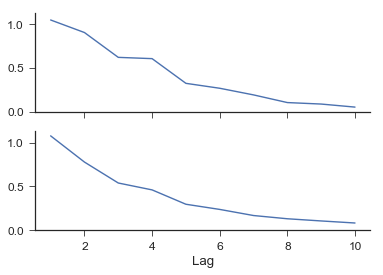

In [10]:
fig,ax = plt.subplots(nrows=2,sharex=True,sharey=True)
ax[0].plot(np.arange(1,11),mi1)
ax[1].plot(np.arange(1,11),mi2)
ax[1].set_xlabel('Lag')
sns.despine()

In [11]:
#fig.savefig('../figures/mutual_info.png',bbox_inches='tight')

### 3. Embed the time series

In [12]:
lag = 1
embed = 2
X1 = e1.embed_vectors_1d(lag,embed)
X2 = e2.embed_vectors_1d(lag,embed)

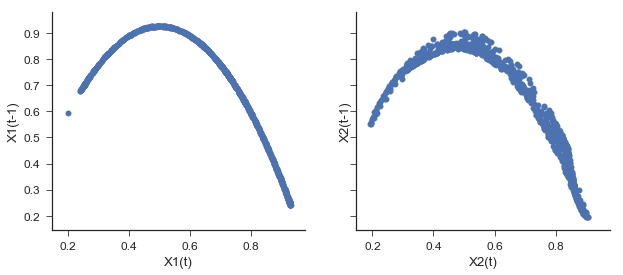

In [13]:
fig,ax = plt.subplots(ncols=2,sharey=True,sharex=True,figsize=(10,4)) 
ax[0].scatter(X1[:,0],X1[:,1])
ax[1].scatter(X2[:,0],X2[:,1])
ax[0].set_xlabel('X1(t)')
ax[0].set_ylabel('X1(t-1)')
ax[1].set_xlabel('X2(t)')
ax[1].set_ylabel('X2(t-1)')
sns.despine()

In [14]:
#fig.savefig('../figures/x_embedded.png',bbox_inches='tight')

### 4. Forecast skill as a function of library length
Same legend as above.

In [15]:
CCM = ccm.CCM()

### Split it into a testing set and training set

In [16]:
from skccm.utilities import train_test_split

In [17]:
x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

In [18]:
len_tr = len(x1tr)
lib_lens = np.linspace(10, len_tr/2, dtype='int')
lib_lens

array([ 10,  17,  24,  32,  39,  47,  54,  62,  69,  76,  84,  91,  99,
       106, 114, 121, 129, 136, 143, 151, 158, 166, 173, 181, 188, 195,
       203, 210, 218, 225, 233, 240, 248, 255, 262, 270, 277, 285, 292,
       300, 307, 314, 322, 329, 337, 344, 352, 359, 367, 374])

In [19]:
CCM.fit(x1tr,x2tr)
x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)

In [20]:
sc1,sc2 = CCM.score()

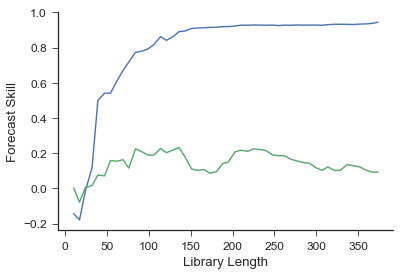

In [21]:
fig,ax = plt.subplots()
ax.plot(lib_lens,sc1,label='X1 xmap X2')
ax.plot(lib_lens,sc2, label='X2 xmap X1')
ax.set_xlabel('Library Length')
ax.set_ylabel('Forecast Skill')
sns.despine()

In [22]:
#fig.savefig('../figures/train_test_split/xmap_lib_len.png',bbox_inches='tight')

## Reproducing the plot from the paper
The paper explores different values for b12 and b21 in Figure 3B.

In [23]:
rx1 = 3.7 #determines chaotic behavior of the x1 series
rx2 = 3.7 #determines chaotic behavior of the x2 series

ts_length = 1000

#variables for embedding
lag = 1
embed = 2

CCM = ccm.CCM() #intitiate the ccm object

#store values
num_b = 20 #number of bs to test
sc1_store = np.empty((num_b,num_b))
sc2_store = np.empty((num_b,num_b))

#values over which to test
max_b = .4 #maximum b values
b_range = np.linspace(0,max_b,num=num_b)

In [24]:
#loop through b values for b12 and b21
for ii,b12 in enumerate(b_range):
    for jj, b21 in enumerate(b_range):
        
        x1,x2 = data.coupled_logistic(rx1,rx2,b12,b21,ts_length)
        
        e1 = ccm.Embed(x1)
        e2 = ccm.Embed(x2)
        
        X1 = e1.embed_vectors_1d(lag,embed)
        X2 = e2.embed_vectors_1d(lag,embed)
        
        x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)
        
        CCM.fit(x1tr,x2tr)
        x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=[500]) #only one prediction
        sc1,sc2 = CCM.score()
        
        
        sc1_store[ii,jj] = sc1[0]
        sc2_store[ii,jj] = sc2[0]
        
sc_diff = sc2_store-sc1_store

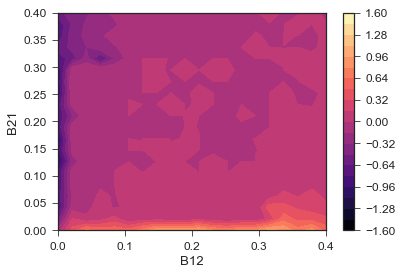

In [25]:
fig,ax = plt.subplots()
v = np.linspace(-1.6,1.6,21)
cax = ax.contourf(b_range,b_range,sc_diff,v,cmap='magma')
fig.colorbar(cax,ticks=v[::2])
ax.set_xlabel('B12')
ax.set_ylabel('B21')

In [26]:
#fig.savefig('../figures/train_test_split/xmap_changingB.png',bbox_inches='tight')

## Randomly forced

In [27]:
rx2 = 3.72 #determines chaotic behavior of the x2 series
b12 = .2 #Influence of x1 on x2

ts_length = 1000
x1,x2 = data.driven_rand_logistic(rx2,b12,ts_length)

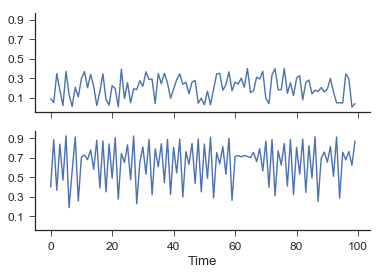

In [28]:
fig,ax = plt.subplots(nrows=2,sharex=True,sharey=True)
ax[0].plot(x1[0:100])
ax[1].plot(x2[0:100])
ax[0].set_yticks([.1,.3,.5,.7,.9])
ax[1].set_xlabel('Time')
sns.despine()

In [29]:
e1 = ccm.Embed(x1)
e2 = ccm.Embed(x2)

In [30]:
mi1 = e1.mutual_information(10)
mi2 = e2.mutual_information(10)

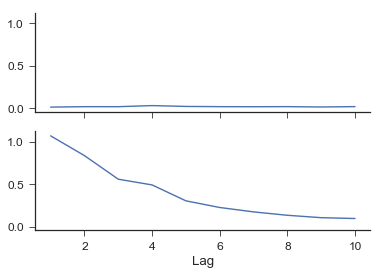

In [31]:
fig,ax = plt.subplots(nrows=2,sharex=True,sharey=True)
ax[0].plot(np.arange(1,11),mi1)
ax[1].plot(np.arange(1,11),mi2)
ax[1].set_xlabel('Lag')
sns.despine()

In [32]:
lag = 1
embed = 3

X1 = e1.embed_vectors_1d(lag,embed)
X2 = e2.embed_vectors_1d(lag,embed)

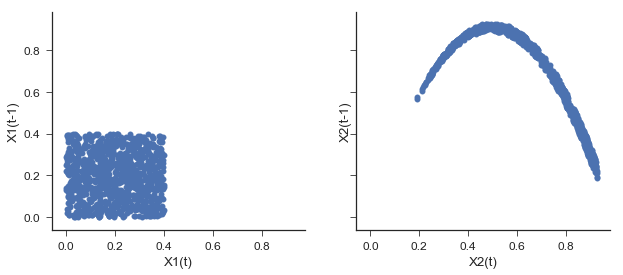

In [33]:
fig,ax = plt.subplots(ncols=2,sharey=True,sharex=True,figsize=(10,4)) 
ax[0].scatter(X1[:,0],X1[:,1])
ax[1].scatter(X2[:,0],X2[:,1])
ax[0].set_xlabel('X1(t)')
ax[0].set_ylabel('X1(t-1)')
ax[1].set_xlabel('X2(t)')
ax[1].set_ylabel('X2(t-1)')
sns.despine()

In [34]:
CCM = ccm.CCM()

In [35]:
lib_lens = np.linspace(10,ts_length/2,dtype='int')

x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

CCM.fit(x1tr,x2tr)
x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens) #only one prediction
sc1,sc2 = CCM.score()

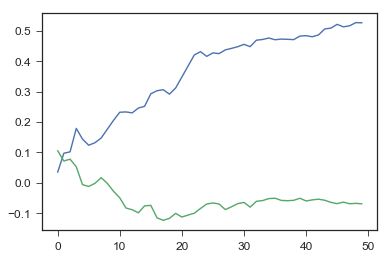

In [36]:
plt.plot(sc1)
plt.plot(sc2)

## Periodic Forcing

In [37]:
rx2 = 3.72 #determines chaotic behavior of the x2 series
b12 = .5 #Influence of x1 on x2

ts_length = 1000
x1,x2 = data.driving_sin(rx2,b12,ts_length)

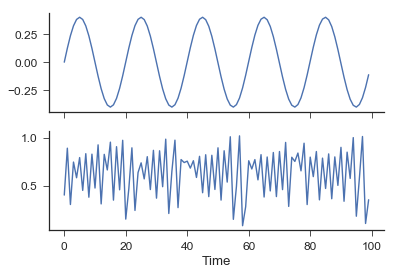

In [38]:
fig,ax = plt.subplots(nrows=2,sharex=True)
ax[0].plot(x1[0:100])
ax[1].plot(x2[0:100])
ax[1].set_xlabel('Time')
sns.despine()

In [39]:
em_x1 = ccm.Embed(x1)
em_x2 = ccm.Embed(x2)

In [40]:
mi1 = em_x1.mutual_information(10)
mi2 = em_x2.mutual_information(10)

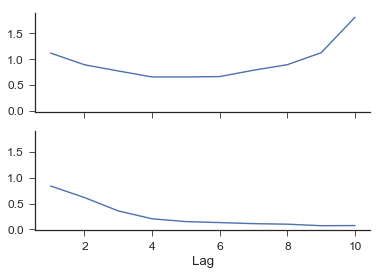

In [41]:
fig,ax = plt.subplots(nrows=2,sharex=True,sharey=True)
ax[0].plot(np.arange(1,11),mi1)
ax[1].plot(np.arange(1,11),mi2)
ax[1].set_xlabel('Lag')
sns.despine()

In [42]:
lag1 = 4
lag2 = 1
embed = 3

X1 = em_x1.embed_vectors_1d(lag1,embed)
X2 = em_x2.embed_vectors_1d(lag2,embed)

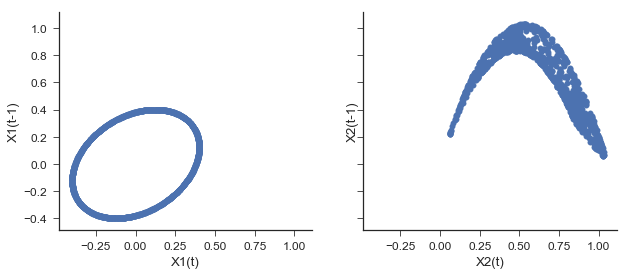

In [43]:
fig,ax = plt.subplots(ncols=2,sharey=True,sharex=True,figsize=(10,4)) 
ax[0].scatter(X1[:,0],X1[:,1])
ax[1].scatter(X2[:,0],X2[:,1])
ax[0].set_xlabel('X1(t)')
ax[0].set_ylabel('X1(t-1)')
ax[1].set_xlabel('X2(t)')
ax[1].set_ylabel('X2(t-1)')
sns.despine()

In [44]:
CCM = ccm.CCM()

In [45]:
print('X1 Shape:', X1.shape)
print('X2 Shape:', X2.shape)

X1 Shape: (992, 3)
X2 Shape: (998, 3)


Need to make them the same length before they can be used. This could be corrected in future versions.

In [46]:
X2 = X2[0:len(X1)]

In [47]:
lib_lens = np.linspace(10,ts_length/2,dtype='int')

x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

CCM.fit(x1tr,x2tr)
x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens) #only one prediction
sc1,sc2 = CCM.score()

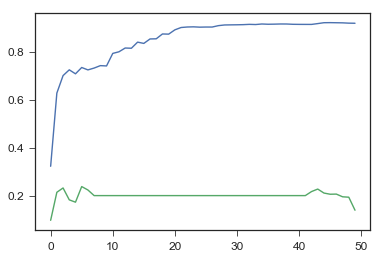

In [48]:
plt.plot(sc1)
plt.plot(sc2)

In [49]:
x1p[-1].shape

(248, 3)

In [50]:
x1te.shape

(248, 3)

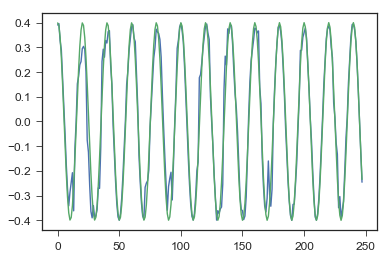

In [51]:
plt.plot(x1p[-1][:,0])
plt.plot(x1te[:,0])

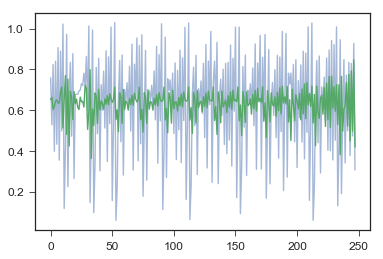

In [52]:
plt.plot(x2te[:,0],alpha=.5)
plt.plot(x2p[-1][:,0])

## Lagged Coupled Logistic

In [53]:
rx1 = 3.72 #determines chaotic behavior of the x1 series
rx2 = 3.72 #determines chaotic behavior of the x2 series
b12 = 0.01 #Influence of x1 on x2
b21 = 0.3 #Influence of x2 on x1
ts_length = 8000
x1,x2 = data.lagged_coupled_logistic(rx1,rx2,b12,b21,ts_length)

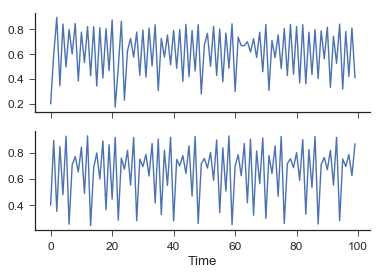

In [54]:
fig,ax = plt.subplots(nrows=2,sharex=True)
ax[0].plot(x1[0:100])
ax[1].plot(x2[0:100])
ax[1].set_xlabel('Time')
sns.despine()

In [55]:
em_x1 = ccm.Embed(x1)
em_x2 = ccm.Embed(x2)

In [56]:
mi1 = em_x1.mutual_information(10)
mi2 = em_x2.mutual_information(10)

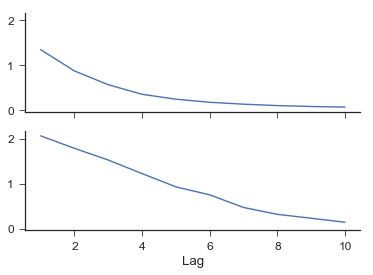

In [57]:
fig,ax = plt.subplots(nrows=2,sharex=True,sharey=True)
ax[0].plot(np.arange(1,11),mi1)
ax[1].plot(np.arange(1,11),mi2)
ax[1].set_xlabel('Lag')
sns.despine()

In [58]:
lag1 = 2
lag2 = 2
embed = 3

X1 = em_x1.embed_vectors_1d(lag1,embed)
X2 = em_x2.embed_vectors_1d(lag2,embed)

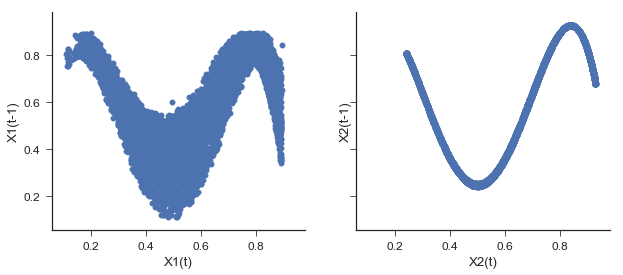

In [59]:
fig,ax = plt.subplots(ncols=2,sharey=True,sharex=True,figsize=(10,4)) 
ax[0].scatter(X1[:,0],X1[:,1])
ax[1].scatter(X2[:,0],X2[:,1])
ax[0].set_xlabel('X1(t)')
ax[0].set_ylabel('X1(t-1)')
ax[1].set_xlabel('X2(t)')
ax[1].set_ylabel('X2(t-1)')
sns.despine()

In [60]:
CCM = ccm.CCM()

In [61]:
lib_lens = np.linspace(10,ts_length/2,dtype='int')

x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

CCM.fit(x1tr,x2tr)
x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens) #only one prediction
sc1,sc2 = CCM.score()

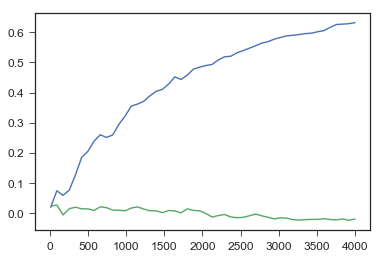

In [62]:
plt.plot(lib_lens,sc1)
plt.plot(lib_lens,sc2)

## Random Linearly Increasing

In [63]:
ts_length=1000
x1 = np.random.randn(ts_length,) + np.linspace(0,25,ts_length)
x2 = np.random.randn(ts_length,) + np.linspace(0,10,ts_length)

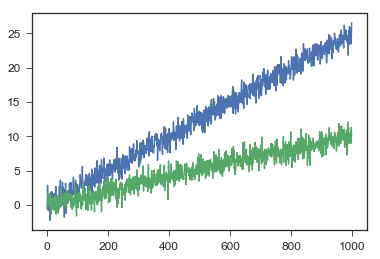

In [64]:
plt.plot(x1)
plt.plot(x2)

In [65]:
em_x1 = ccm.Embed(x1)
em_x2 = ccm.Embed(x2)

In [66]:
mi1 = em_x1.mutual_information(20)
mi2 = em_x2.mutual_information(20)

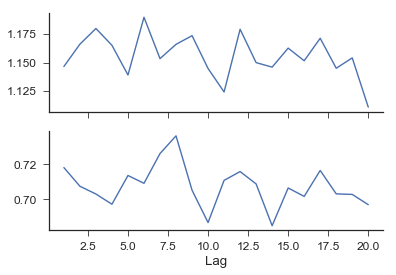

In [67]:
fig,ax = plt.subplots(nrows=2,sharex=True)
ax[0].plot(np.arange(1,21),mi1)
ax[1].plot(np.arange(1,21),mi2)
ax[1].set_xlabel('Lag')
sns.despine()

In [68]:
lag1 = 2
lag2 = 2
embed = 8

X1 = em_x1.embed_vectors_1d(lag1,embed)
X2 = em_x2.embed_vectors_1d(lag2,embed)

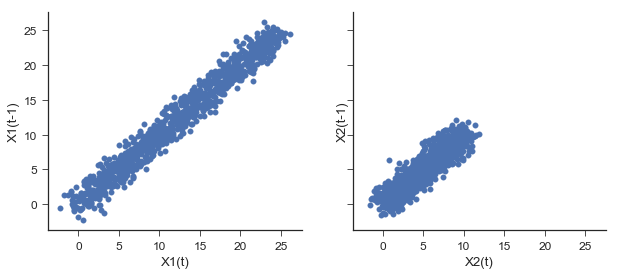

In [69]:
fig,ax = plt.subplots(ncols=2,sharey=True,sharex=True,figsize=(10,4)) 
ax[0].scatter(X1[:,0],X1[:,1])
ax[1].scatter(X2[:,0],X2[:,1])
ax[0].set_xlabel('X1(t)')
ax[0].set_ylabel('X1(t-1)')
ax[1].set_xlabel('X2(t)')
ax[1].set_ylabel('X2(t-1)')
sns.despine()

In [70]:
CCM = ccm.CCM()

In [71]:
lib_lens = np.linspace(10,ts_length/2,dtype='int')

x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

CCM.fit(x1tr,x2tr)
x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens) #only one prediction
sc1,sc2 = CCM.score()

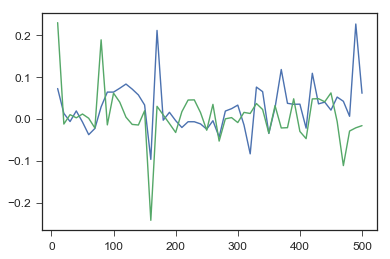

In [72]:
plt.plot(lib_lens,sc1)
plt.plot(lib_lens,sc2)

### Cosine and Sine Waves

In [73]:
ts_length=500
x1 = np.random.randn(ts_length,) + 10*np.sin(np.linspace(0,10*np.pi,ts_length))
x2 = np.random.randn(ts_length,) + 20*np.cos(np.linspace(0,10*np.pi,ts_length))

#x1[x1<0] = np.random.randn(np.sum(x1<0),)
#x2[x2<0] = np.random.randn(np.sum(x2<0),)

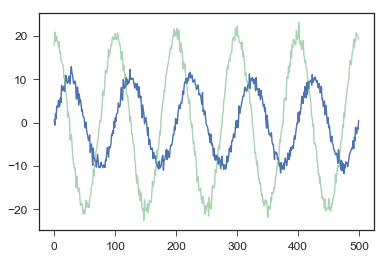

In [74]:
plt.plot(x1)
plt.plot(x2,alpha=.5)

In [75]:
em_x1 = ccm.Embed(x1)
em_x2 = ccm.Embed(x2)
mi1 = em_x1.mutual_information(100)
mi2 = em_x2.mutual_information(100)

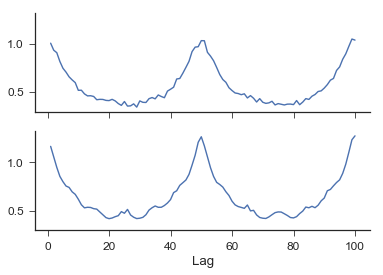

In [76]:
fig,ax = plt.subplots(nrows=2,sharex=True,sharey=True)
ax[0].plot(np.arange(1,101),mi1)
ax[1].plot(np.arange(1,101),mi2)
ax[1].set_xlabel('Lag')
sns.despine()

In [77]:
lag1 = 20
lag2 = 20
embed = 2

X1 = em_x1.embed_vectors_1d(lag1,embed)
X2 = em_x2.embed_vectors_1d(lag2,embed)

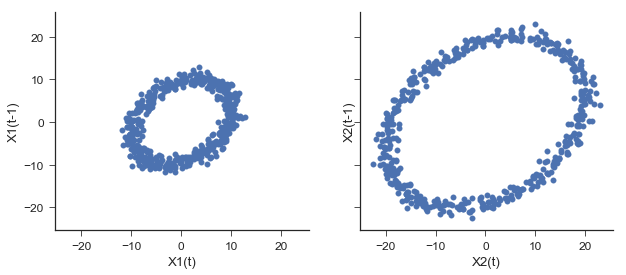

In [78]:
fig,ax = plt.subplots(ncols=2,sharey=True,sharex=True,figsize=(10,4)) 
ax[0].scatter(X1[:,0],X1[:,1])
ax[1].scatter(X2[:,0],X2[:,1])
ax[0].set_xlabel('X1(t)')
ax[0].set_ylabel('X1(t-1)')
ax[1].set_xlabel('X2(t)')
ax[1].set_ylabel('X2(t-1)')
sns.despine()

In [79]:
CCM = ccm.CCM()

In [80]:
lib_lens = np.linspace(10,ts_length/2,dtype='int')

x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

CCM.fit(x1tr,x2tr)
x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens) #only one prediction
sc1,sc2 = CCM.score()

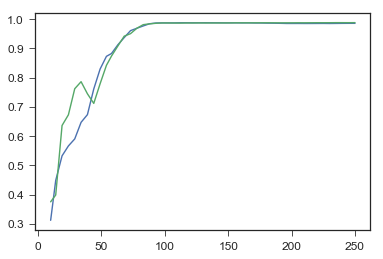

In [81]:
plt.plot(lib_lens,sc1)
plt.plot(lib_lens,sc2)

### Lorenz

In [82]:
X = data.lorenz()

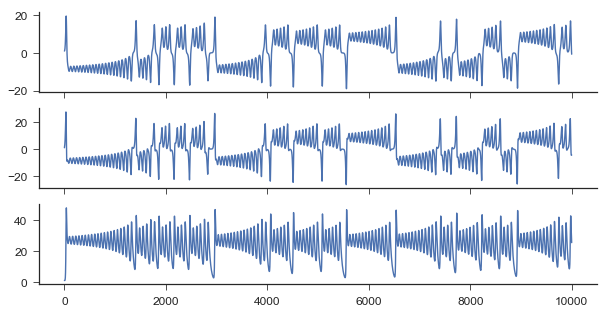

In [83]:
fig,ax = plt.subplots(3,figsize=(10,5),sharex=True)
ax[0].plot(X[:,0])
ax[1].plot(X[:,1])
ax[2].plot(X[:,2])
sns.despine()

In [84]:
e1 = ccm.Embed(X[:,0])
e2 = ccm.Embed(X[:,2])
mi1 = e1.mutual_information(100)
mi2 = e2.mutual_information(100)

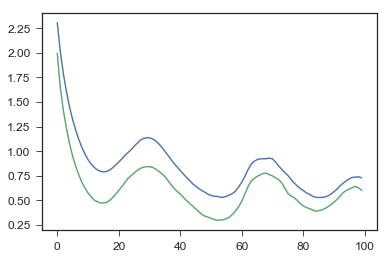

In [85]:
plt.plot(mi1)
plt.plot(mi2)

In [86]:
lag = 18
embed = 3
X1 = e1.embed_vectors_1d(lag,embed)
X2 = e2.embed_vectors_1d(lag,embed)

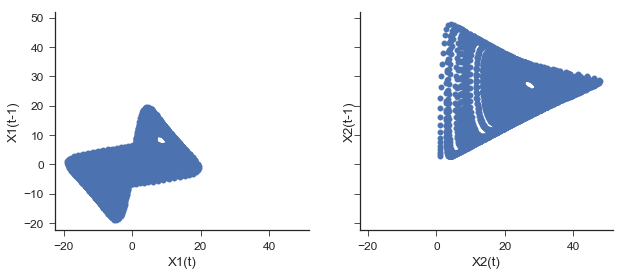

In [87]:
fig,ax = plt.subplots(ncols=2,sharey=True,sharex=True,figsize=(10,4)) 
ax[0].scatter(X1[:,0],X1[:,1])
ax[1].scatter(X2[:,0],X2[:,1])
ax[0].set_xlabel('X1(t)')
ax[0].set_ylabel('X1(t-1)')
ax[1].set_xlabel('X2(t)')
ax[1].set_ylabel('X2(t-1)')
sns.despine()

In [88]:
CCM = ccm.CCM()

In [89]:
lib_lens = np.linspace(10,ts_length/2,dtype='int')

x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

CCM.fit(x1tr,x2tr)
x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens) #only one prediction
sc1,sc2 = CCM.score()

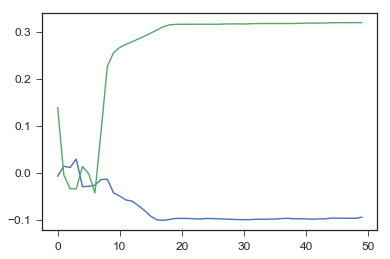

In [90]:
plt.plot(sc1)
plt.plot(sc2)